Prototype of a VGP identification network

In [1]:
% cd  ../

/mnt/fs1/mayu-ot/Experiments/loc_iparaphrasing


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [13]:
import chainer
from chainer import initializers
import chainer.functions as F
import chainer.links as L
import numpy as np
from chainercv.links import FasterRCNNVGG16
from func.nets.gate_net import PhraseNet, ImgNet, MultiModalClassifierNet
from imageio import imread
from chainercv.visualizations import vis_bbox
from chainer.dataset.convert import to_device

In [4]:
from chainer import cuda
from chainercv.links.model.faster_rcnn.utils.loc2bbox import loc2bbox
from chainercv.utils import non_maximum_suppression
from chainercv.links.model.faster_rcnn.faster_rcnn_vgg import _roi_pooling_2d_yx

class Extractor(FasterRCNNVGG16):
    def proc_head(self, x, rois, roi_indices):
        roi_indices = roi_indices.astype(np.float32)
        indices_and_rois = self.xp.concatenate(
            (roi_indices[:, None], rois), axis=1)
        pool = _roi_pooling_2d_yx(
            x, indices_and_rois, self.head.roi_size, self.head.roi_size,
            self.head.spatial_scale)

        fc6 = F.relu(self.head.fc6(pool))
        fc7 = F.relu(self.head.fc7(fc6))
        roi_cls_locs = self.head.cls_loc(fc7)
        roi_scores = self.head.score(fc7)
        return fc7, roi_cls_locs, roi_scores
    
    def extract_region_feat(self, x, scale):
        img_size = x.shape[2:]

        h = self.extractor(x)
        rpn_locs, rpn_scores, rois, roi_indices, anchor =\
            self.rpn(h, img_size, scale)
        fc7, roi_cls_locs, roi_scores = self.proc_head(
            h, rois, roi_indices)
        return fc7, roi_cls_locs, roi_scores, rois, roi_indices
    
    def __call__(self, imgs):
        prepared_imgs = []
        sizes = []
        for img in imgs:
            size = img.shape[1:]
            img = self.prepare(img.astype(np.float32))
            prepared_imgs.append(img)
            sizes.append(size)

        bboxes = []
        feats = []
        for img, size in zip(prepared_imgs, sizes):
            with chainer.using_config('train', False), \
                    chainer.function.no_backprop_mode():
                img_var = chainer.Variable(self.xp.asarray(img[None]))
                scale = img_var.shape[3] / size[1]
                region_feat, roi_cls_locs, roi_scores, rois, _ = self.extract_region_feat(img_var, scale=scale)
            # We are assuming that batch size is 1.
            region_feat = region_feat.array
            roi_cls_loc = roi_cls_locs.array
            roi_score = roi_scores.array
            roi = rois / scale

            # Convert predictions to bounding boxes in image coordinates.
            # Bounding boxes are scaled to the scale of the input images.
            mean = self.xp.tile(self.xp.asarray(self.loc_normalize_mean),
                                self.n_class)
            std = self.xp.tile(self.xp.asarray(self.loc_normalize_std),
                               self.n_class)
            roi_cls_loc = (roi_cls_loc * std + mean).astype(np.float32)
            roi_cls_loc = roi_cls_loc.reshape((-1, self.n_class, 4))
            
            roi[:, 0::2] = self.xp.clip(roi[:, 0::2], 0, size[0])
            roi[:, 1::2] = self.xp.clip(roi[:, 1::2], 0, size[1])
            
            feats.append(region_feat)
            bboxes.append(roi)
        return feats, bboxes

In [5]:
model = Extractor(20, pretrained_model='voc07', proposal_creator_params={'n_test_post_nms': 30})

In [6]:
model.rpn.proposal_layer.nms_thresh = 0.1
imgs = [imread('data/flickr30k-images/390369.jpg').transpose(2,0,1)]
feats, bboxes = model(imgs)

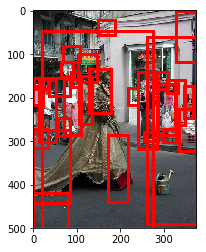

In [7]:
vis_bbox(imgs[0], bboxes[0])

In [8]:
class AttentionNetGTP(chainer.Chain):
    def __init__(self, h_size=300):
        super(AttentionNetGTP, self).__init__()
        with self.init_scope():
            # attention net
            self.fc_ar = L.Linear(None, h_size, initialW=initializers.LeCunNormal())
            self.fc_ap = L.Linear(None, h_size, initialW=initializers.LeCunNormal(), nobias=True)      
            self.fc_att = L.Linear(None, 1, initialW=initializers.HeNormal(), nobias=True)

    def __call__(self, phr_feats, region_feats, region_label=None):
        B, N, C = region_feats.shape

        hr = F.reshape(region_feats, (-1, C))

        hr =  self.fc_ap(hr)
        hr = F.reshape(hr, (B, N, -1))

        hp = self.fc_ar(phr_feats)
        hp = F.expand_dims(hp, axis=1)

        h = F.relu(F.broadcast_to(hp, hr.shape) + hr)
        h = F.reshape(h, (-1, h.shape[-1]))

        a = self.fc_att(h)
        a = F.reshape(a, (B, N))
        a = F.softmax(a, axis=1)
        
        return a

class AttentionNetWTL(chainer.Chain):
    def __init__(self, h_size=300):
        super(AttentionNetWTL, self).__init__()
        with self.init_scope():            
            # attention net
            self.fc_ar = L.Linear(None, h_size, initialW=initializers.LeCunNormal())
            self.fc_ap = L.Linear(None, h_size, initialW=initializers.LeCunNormal())        

    def __call__(self, phr_feats, region_feats, region_label=None):
        B, N, C = region_feats.shape

        hr = F.reshape(region_feats, (-1, C))
        hr = self.fc_ar(hr)
        hr = F.reshape(hr, (B, N, -1))

        hp = self.fc_ap(phr_feats)
        hp = F.expand_dims(hp, axis=1)

        a = F.matmul(hr, hp, transb=True)
        a = F.reshape(a, (B, N))
        a = F.softmax(a, axis=1)
        
        return a 

class Net(chainer.Chain):
    def __init__(self, attention_net=None):
        super(Net, self).__init__()
        with self.init_scope():
            self.extractor = Extractor(20, pretrained_model='voc07', proposal_creator_params={'n_test_post_nms': 30})
            self.phr_net = PhraseNet(1000)
            self.att_net = attention_net
            self.img_net = ImgNet(1000)
            self.classifier = MultiModalClassifierNet(out_size=300)
            
    def __call__(self, phr_1, phr_2, imgs, l):
        feats, bboxes = self.extractor(imgs)
        feats = self.xp.stack(feats)
#         bboxes = self.xp.bboxes(bboxes)
        
        att_1 = self.att_net(phr_1, feats)
        att_2 = self.att_net(phr_2, feats)
        
        att_1 = F.broadcast_to(F.expand_dims(att_1, axis=2), feats.shape)
        att_2 = F.broadcast_to(F.expand_dims(att_2, axis=2), feats.shape)
        
        h_v1 = F.average(feats * att_1, axis=1)
        h_v2 = F.average(feats * att_2, axis=1)
        
        h_p = self.phr_net(phr_1, phr_2)
        h_v = self.img_net(h_v1, h_v2)
        
        y = self.classifier(h_p, h_v)
        loss = F.sigmoid_cross_entropy(y, l)
        
        return loss

In [11]:
# att_net = AttentionNetWTL()
att_net = AttentionNetGTP()
model = Net(attention_net = att_net)
model.to_gpu()

In [15]:
phr_1 = to_device(0, np.random.random((1, 300)).astype('f'))
phr_2 = to_device(0, np.random.random((1, 300)).astype('f'))
imgs = [imread('data/flickr30k-images/390369.jpg').transpose(2,0,1)]
l = to_device(0, np.asarray([1]).astype('i'))

loss = model(phr_1, phr_2, imgs, l)

/home/mayu-ot/miniconda3/envs/py36chainer/lib/python3.6/site-packages/chainer/functions/normalization/batch_normalization.py:67: UserWarning: A batch with no more than one sample has been given to F.batch_normalization. F.batch_normalization will always output a zero tensor for such batches. This could be caused by incorrect configuration in your code (such as running evaluation while chainer.config.train=True), but could also happen in the last batch of training if non-repeating iterator is used.
  UserWarning)
